__관련 링크__  
[openface pip line 구현](https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c)

[이미지 인코딩](https://www.popit.kr/openface-exo-member-face-recognition/)

# library 설치
- openface
    - cmd
    - git clone https://github.com/cmusatyalab/openface.git
    - cd openface
    - pip install -r requirements.txt
        - ![image](https://user-images.githubusercontent.com/28910538/57053044-637d6f00-6cc6-11e9-9205-a975fa889417.png)
    - python setup.py install
        - ![image](https://user-images.githubusercontent.com/28910538/57053058-827c0100-6cc6-11e9-85d1-881fdf298d34.png)
    - cd models
    - get-models.sh

# 이미지 얼굴 검출
- pip install cv2

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

img = cv2.imread('./images/image1.png')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# scaleFactor : 각 이미지크기에서 이미지크기가 감소되는 양
# 크기를 줄임으로써 감지 모델과 일치할 확률 증가하지만 더 느려짐
# minNeighbors : 각 후보 사각형을 유지해야하는 이웃 수를 지정
#, 값이 높을 수록 탐지는 적지만 품질은 높아짐
faces = face_cascade.detectMultiScale(gray_img,scaleFactor=1.1, minNeighbors=5)
print(faces)
for (x,y,w,h) in faces:
    print(1)
    img = cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
    y_ = y
    y_h = y+h
    x_ = x
    x_w = x+w
    roi_gray = gray_img[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

[[213 115 208 208]]
1


In [2]:
print("{} 순서대로 x,y,w,h".format(faces))

[[213 115 208 208]] 순서대로 x,y,w,h


# 얼굴만 자르고 resize

True

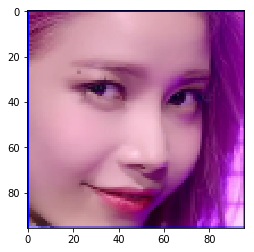

In [3]:
reduction_img = img[y_:y_h, x_:x_w]
reduction_img = cv2.resize(reduction_img,dsize=(96,96))
plt.imshow(reduction_img)
reduction_img = cv2.cvtColor(reduction_img, cv2.COLOR_BGR2RGB)
# 저장
cv2.imwrite('./images/reduction_img.jpg', reduction_img)

In [4]:
# # plt.imshow(img1[115:115+208, 213:213+208])
# img = img[faces[0,1]:faces[0,1]+faces[0,3],faces[0,0]:faces[0,0]+faces[0,2]]
# #img1 = cv2.resize(img1,dsize=(24,24), interpolation = cv2.INTER_AREA)
# img = cv2.resize(img,dsize=(96,96))
# plt.imshow(img)

# 이미지에서 landmark detection
- pip install dlib하면 되는데 error
    - 해결 방법
        - https://stackoverflow.com/questions/41912372/dlib-installation-on-windows-10
        - pip install cmake
        - install visual studio build tools
        - In Visual Studio 2017 go to the Individual Components tab, Visual C++ Tools for Cmake, and check the checkbox under the "Compilers, build tools and runtimes" section.
        - pip install dlib
- 근데 난 아래 처럼 진행함
    - visual studio도 깔려 있었어서 그냥 바로 cmake 후 dlib
    - pip install cmake
    - pip install dlib

## cmak이란
- 기존 프로젝트 구성은 특정 IDE나 특정 빌드 도구에 한정되어 하나의 형식으로 한정되게 되는데 (예:visual studio의 sln/vcproj를 다른 플랫폼에서 바로 빌드할 수 없음) 이런 문제점을 CMake를 통해 해결할 수 있음


## 얼굴 검출 위한 pip line
- https://cmusatyalab.github.io/openface/
- ![image](https://user-images.githubusercontent.com/28910538/57051939-016d3b80-6cbf-11e9-911f-62fc4b8d6241.png)

### OpenFace란
- OpenFace는 Python 및 Torch 의 심층 신경망을 이용한 얼굴 인식으로, CVPR 2015 논문 인 FaceNet : Google의 Florian Schroff, Dmitry Kalenichenko 및 James Philbin이 Face Recognition 및 Clustering 을 위한 통합 임베딩을 기반으로합니다 . 토치는 네트워크가 CPU 또는 CUDA에서 실행되도록합니다.


### dlib란
- 이미지 처리 및 기계 학습, 얼굴 인식 등을 할 수 있는 c++로 개발된 고성능의 라이브러리
- opencv와 뭐가 다른건가 싶겠지만 
    - 얼굴인식에 관해서는 dlib가 강력함
    - 밝기가 변하는 방향을 고려해서 얼굴인식
    ![image](https://user-images.githubusercontent.com/28910538/56934340-8b35d100-6b26-11e9-82d0-a98862c3d815.png)

    - 이미지 처리에 대해서는 opencv가 강력

### dlib로 얼굴 검출
- HOG로 학습되어있는 모델 통해 HOG 검출하고 그 값으로 얼굴 인식

In [1]:
import dlib
import numpy as np
import cv2
import matplotlib.pyplot as plt
import openface

# 여러 얼굴 나왔을 때 가장 영역이 크게 나오는 이미지로 검출
# 추 후 여러 얼굴을 뽑아내게 수정
def detected_face(face_area, one_image=True):
    # 검출되는 얼굴영역이 여러개 일때는
    # 가장 크게 잡힌 영역을 얼굴로 보도록 함
    if len(face_area) > 1:
        if one_image:
            max_rect_area = [0,0]
            for i, rect in enumerate(face_area):
                rect_area = ((rect.top() - rect.bottom()) * (rect.right()- rect.left()))
                if rect_area > max_rect_area[1]:
                    max_rect_area = [i, rect_area]
    else:
        return [face_area[0]]
    
    return [face_area[max_rect_area[0]]]

# land mark를 포함하는 rect 좌표
# land mark의 범위로 이미지를 잘라내기 위함
def min_max_pos(landmakrs_pos):
    x_list = []
    y_list = []
    for pos in landmakrs_pos:
        x_list.append(pos.x)
        y_list.append(pos.y)
    left_top = (min(x_list)-1, max(y_list)+1)
    right_bottom = (max(x_list)+1, min(y_list)-1)
    return left_top, right_bottom

left : 216 top : 118 right : 439 bottom : 341


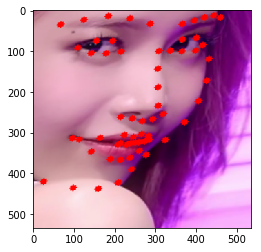

In [2]:
img = cv2.imread('./images/image1.png')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# land mark 찍는 model
predictor_model = "./shape_predictor_68_face_landmarks.dat"

face_detector = dlib.get_frontal_face_detector()
face_area = face_detector(gray_img, 1)
# land mark 검출
face_pose_predictor = dlib.shape_predictor(predictor_model)
# affine transformation
face_aligner = openface.AlignDlib(predictor_model)
# 얼굴이 검출 됐을 때
if len(face_area) != 0:
# 얼굴이 검출 됐을때 얼굴이 여러개나오면 가장 큰 영역 얼굴로 사용
    face_rect = detected_face(face_area)
    for fr in face_rect:
        print("left : {} top : {} right : {} bottom : {}".format(fr.left(), fr.top(), fr.right(), fr.bottom()))
        # land mark 찍고(이미지, 검출된 얼굴 rect)
        pose_landmarks = face_pose_predictor(img, fr)
        left_top, right_bottom = min_max_pos(pose_landmarks.parts())
        # land mark 기준으로 얼굴영역 자르
        reduction_img = img[right_bottom[1]:left_top[1], left_top[0]:right_bottom[0]]
        # land mark 찍어줌
        for pos in pose_landmarks.parts():
            cv2.circle(img, (pos.x,pos.y), 3, (0, 0, 255), -1)
        # land mark 통해 얼굴을 앞쪽을 보는 것처럼
        alignedFace = face_aligner.align(534, img, fr, landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)

        # plt로 출력하려면 bgr을 rgb로 바꿔줘야함
        alignedFace = cv2.cvtColor(alignedFace, cv2.COLOR_BGR2RGB)
        #alignedFace = cv2.resize(alignedFace, (96,96))
    plt.imshow(alignedFace)    

In [3]:
openface.TorchNeuralNet.defaultModel

'C:\\ProgramData\\Anaconda3\\envs\\gpu_env\\lib\\site-packages\\openface\\..\\models\\openface\\nn4.small2.v1.t7'

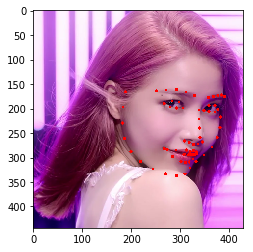

In [24]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)    

### Affine transformation
- 길이, 각의 크기, 넓이 등은 가지지않지만 평행한 성질은 갖게함

In [13]:
import os
import cv2
import dlib
import shutil
import openface

print("Start program")

print("Model loading...")

# embedding을 해 주는 신경망이 저장된 경로
predictor_model = "./shape_predictor_68_face_landmarks.dat"

# dlib 내장 얼굴 인식용 Hog Face Detector
face_detector = dlib.get_frontal_face_detector()

# 얼굴의 자세를 인식하고 보정해줄 aligner
face_pose_predictor = dlib.shape_predictor(predictor_model)
face_aligner = openface.AlignDlib(predictor_model)

print("Model loading finished.\n")

# 주어진 이미지에서 얼굴을 추출해서 정렬한 후 반환함.
# img는 얼굴을 추출할 이미지, img_dim은 정렬된 이미지(정사각형)의 한 변의 길이.
def align_face(img, img_dim):
    
    # 이미지가 None이 아닌지 체크
    assert img is not None

    detected_faces = face_detector(img, 1)
    
    # 주어진 이미지에서 얼굴이 1개가 맞는지 체크
    assert len(detected_faces) is 1

    face_rect = detected_faces[0]

    # 얼굴의 포즈를 가져 와서 정렬함. 그런데 첫 번째의 534가 뭔지는 저도 잘 모르겠습니다.
    aligned_face = face_aligner.align(534, img, face_rect, landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)

    # 이미지를 사이즈에 맞게 바꿈.
    aligned_face = cv2.resize(aligned_face, (img_dim, img_dim))

    return aligned_face


# 주어진 디렉토리의 모든 이미지를 정렬하여 저장함.
def align_face_dir(dir, img_dim):

    # 저장할 디렉토리 경로를 생성함. 원래 폴더의 이름+aligned를 하여, 실행 파일이 포함된 경로에 저장.
    # 함수를 실행하면 자동으로 경로를 알려줌.
    print("Start the image alignment.")
    path = os.path.split(dir)
    save_path = "./" + path[len(path) - 1] + "_aligned"
    print("Aligned image will be saved at", save_path)

    # 만약 이미 그런 경로가 존재할 경우, 경로를 싹 지워버리고 새로 만듬.
    if os.path.exists(save_path):
        shutil.rmtree(save_path)
    else:
        os.mkdir(save_path)

    # 전체 이미지 개수
    count_all = 0
    # 그 중에서 오류 없이 처리한 개수
    count_processed = 0

    for file in os.listdir(dir):
        count_all += 1
        image = cv2.imread(os.path.join(dir, file))
        try:
            aligned = align_face(image, img_dim)
            cv2.imwrite(os.path.join(save_path, file), aligned)
            count_processed += 1
        except AssertionError:
            print("Image processing error :", file)

    # 전체 몇 개 중에서 몇 개가 변환되었는지 출력함.
    print(count_processed, "out of", count_all, "image aligned.\n")


# 위의 함수들을 이용하여 Embedding을 추출할 데이터셋을 만듬.
align_face_dir("./training-images/obama_origin", 96) #오바마
align_face_dir("./training-images/trump_origin", 96) #트럼프